## Week 11 Lab exercises

In this week we will solve a non linear elliptic PDE using relaxation, essentially by recasting it as a parabolic equation and looking for a stationary solution. Below is some code from previous weeks that you may wish to reuse.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Here is the 5 point finite derivative matrix for a second spatial derivative.

def get_FD_second_derivative_matrix(a_N) :
    
    h = 2.0 / a_N
    one_over_h2 = 1.0 / (h*h)
    D2_matrix = np.zeros([a_N+1,a_N+1])

    indices = np.arange(a_N+1)
    for idx_i in indices :
        for idx_j in indices :
            if(idx_i == idx_j) :
                D2_matrix[idx_i,idx_j] = -30.0/12.0 * one_over_h2

            elif (idx_i == (idx_j+2)) :
                D2_matrix[idx_i,idx_j] = -1.0/12.0 * one_over_h2
                
            elif (idx_i == (idx_j+1)) :
                D2_matrix[idx_i,idx_j] = 16.0/12.0 * one_over_h2
                
            elif (idx_i == (idx_j-1)) :
                D2_matrix[idx_i,idx_j] = 16.0/12.0 * one_over_h2

            elif (idx_i == (idx_j-2)) :
                D2_matrix[idx_i,idx_j] = -1.0/12.0 * one_over_h2
                
            else :
                D2_matrix[idx_i,idx_j] = 0.0
                
    # Fix the ends with one sided derivatives
    D2_matrix[0,0] = 1.0 * one_over_h2
    D2_matrix[0,1] = -2.0 * one_over_h2
    D2_matrix[0,2] = 1.0 * one_over_h2
    D2_matrix[a_N,a_N] = 1.0 * one_over_h2
    D2_matrix[a_N,a_N-1] = -2.0 * one_over_h2
    D2_matrix[a_N,a_N-2] = 1.0 * one_over_h2
    
    return D2_matrix

In [3]:
# First make a class for the Heat Equation

class HeatEquationPDE :
    
    """
    Represents the Heat Equation equation PDE and its solution
    
    attributes: alpha (diffusivity), x_0, T_0 (an initial condition),
                N_grid (the size of the grid)
    
    """
    
    # constructor function
    def __init__(self, a_x, a_T0, a_max_time, a_alpha=0.5):
        self.alpha = a_alpha
        self.max_time = a_max_time
        self.x = a_x
        self.T0 = a_T0
        self.N_grid = np.size(a_x)            
        self._solution_t = []
        self._solution_y = []
        
        self.initial_value = self.T0
        self.D2_matrix = get_FD_second_derivative_matrix(self.N_grid-1)
            
        # Rescale for the derivative matrix for the interval we are looking at
        b_minus_a = self.x[self.N_grid-1] - self.x[0]
        self.D2_matrix *= 4.0 / b_minus_a / b_minus_a

    def calculate_dydt(self, t, current_state) :
        
        # Just for readability
        dTdt = np.zeros_like(current_state)
        
        # Now actually work out the time derivatives
        dTdt[:] =  self.alpha * np.dot(self.D2_matrix, current_state)
        
        return dTdt       
 
    def integrate_using_solve_ivp(self) :
        
        t_solution = np.linspace(0.0, self.max_time, 100)
        solution = solve_ivp(self.calculate_dydt, [0, self.max_time],
                        self.initial_value, t_eval=t_solution)
        
        self._solution_t = solution.t
        self._solution_y = solution.y
        
        self._solution_solved = True
        
        return solution.t, solution.y

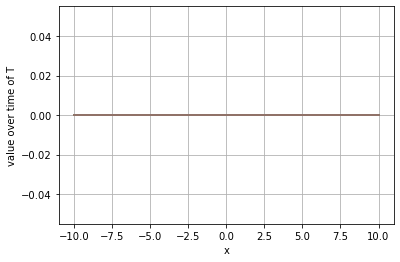

In [4]:
# Test the solution
num_points = 80
a=-10
b=10
x_values = np.linspace(a , b,  num_points)
T0 = np.zeros_like(x_values)
max_time = 10.0

my_heat_equation = HeatEquationPDE(x_values, T0, max_time)
t_solution, y_solution = my_heat_equation.integrate_using_solve_ivp()

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 5 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = y_solution[:,i]
        plt.plot(x_values, f_t, label=labelt, alpha=(1-t_i/max_time))

plt.xlabel('x')
plt.ylabel('value over time of T')
plt.grid()

### Activity 1: Solving the elliptic equation

We want to solve the elliptic equation (ok, it is actually an ODE, but it could also have $+\frac{\partial^2 T}{\partial y^2}$ on the left hand side and the principle would be the same):

$\frac{\partial^2 T}{\partial x^2} = e^{-\alpha T^2}$

With $\alpha$ a parameter for the source that we can set to 0.5, and boundary conditions $T(x=0)=0$ and $T(x=L)=0$, with $L=10$.

So we recast it as a "fake" parabolic equation:

$ \frac{\partial T}{\partial t} = \tau \left[\frac{\partial^2 T}{\partial x^2} - e^{-\alpha T^2}\right] $

With $\tau$ a parameter controlling the relaxation time that we may need to tune.

We now want to solve this equation and find the stationary state, which is a solution of the elliptic equation, i.e. where $ \frac{\partial T}{\partial t}=0$.

1. You should do this first using `solve_ivp()`. 

    - You need to add a method to check that the solution has converged, e.g. by checking that the last few solutions are the same to within some tolerance. 

    - If it is not, how can you tune $\tau$ so that this is achieved? Can $\tau$ take any value? Why not?

    - You should be able to start from any initial guess for the solution (with the correct boundary conditions) and it should converge to the correct one, test this is true.


2. Now solve it using the implicit backward Euler method, that is:

    $y_{k+1} = y_k + \Delta t ~ f(y_{k+1}, t_{k+1})$

    _HINT You may wish to look back to your solution for Week 6 for non linear ODEs._


In [5]:
# Your code here...

In [6]:
# First make a class for the Elliptic Solver

class EllipticSolver :
    
    """
    Solves an elliptic equation by finding the stationary state
    
    attributes: alpha (diffusivity), x_0, T_0 (an initial condition),
                N_grid (the size of the grid)
    
    """
    
    # constructor function
    def __init__(self, a_x, a_T0, a_max_time=1.0, a_alpha=0.5, a_tau=0.1):
        self.alpha = a_alpha
        self.tau = a_tau
        self.max_time = a_max_time
        self.x = a_x
        self.T0 = a_T0
        self.N_grid = np.size(a_x)            
        self._solution_t = []
        self._solution_y = []
        
        self.initial_value = self.T0
        self.D2_matrix = get_FD_second_derivative_matrix(self.N_grid-1)
            
        # Rescale for the derivative matrix for the interval we are looking at
        b_minus_a = self.x[self.N_grid-1] - self.x[0]
        self.D2_matrix *= 4.0 / b_minus_a / b_minus_a

    def calculate_dydt(self, t, current_state) :
        
        # Just for readability
        dTdt = np.zeros_like(current_state)
        
        # Enforce the boundary conditions
        current_state[0] = 0.0
        current_state[self.N_grid-1] = 0.0
        
        # Now work out the time derivatives
        dTdt[:] =  self.tau * np.dot(self.D2_matrix, current_state)
        dTdt[:] += -self.tau * np.exp(- self.alpha * current_state * current_state)
        
        return dTdt       
 
    def integrate_using_solve_ivp(self, a_num_steps=100) :
        
        t_solution = np.linspace(0.0, self.max_time, a_num_steps)
        delta_t = self.max_time / (a_num_steps - 1)
        
        solution = solve_ivp(self.calculate_dydt, [0, self.max_time],
                        self.initial_value, t_eval=t_solution)
        
        self._solution_t = solution.t
        self._solution_y = solution.y
        
        self.check_solution_converged(a_num_steps, delta_t)
        
        return solution.t, solution.y
    
    def integrate_using_implicit_method(self, a_num_steps=1000) :
        
        t_solution = np.linspace(0.0, self.max_time, a_num_steps)
        y_solution = np.zeros([self.N_grid, a_num_steps])
        delta_t = self.max_time / (a_num_steps - 1)
        
        for itime, time in enumerate(t_solution) :
            if itime == 0 :
                y_solution[:,itime] = self.initial_value
            else :
                y_of_t_old   = y_solution[:,itime-1]
                
                # Remember we have to copy if we don't want to actually
                # amend the elements of y_of_t_old
                y_of_t_guess = np.copy(y_of_t_old)
                
                # Implement the iterative scheme described in the lecture
                error = 10.0
                error_threshold = 1e-1
                while (error > error_threshold) :
                    
                    # Get the value of dydt at the guessed value
                    dydt_at_t_next = self.calculate_dydt(time, y_of_t_guess)
                    
                    # Get the new guess using the Euler update rule
                    y_of_t_new = y_of_t_old + delta_t * dydt_at_t_next
                    
                    # If the new guess is the same as the old one we have converged
                    error = np.linalg.norm(y_of_t_guess - y_of_t_new)
                    y_of_t_guess = y_of_t_new
                    
                    # Check it is not getting worse!
                    assert error < 20.0, 'Non linear iterations not converging!'
                    
                # Now (assuming it has converged) assign the 
                # value we found to the solution and continue the time iteration
                # Enforce the boundary conditions
                y_of_t_guess[0] = 0.0
                y_of_t_guess[self.N_grid-1] = 0.0
                y_solution[:,itime] = y_of_t_guess
                
        self._solution_t = t_solution
        self._solution_y = y_solution
        self.check_solution_converged(a_num_steps, delta_t)
        
        return t_solution, y_solution
    
    def check_solution_converged(self, a_num_steps, a_delta_t) :
        
        # Check whether the solution is converged
        last_but_one_solution = self._solution_y[:,a_num_steps-2]
        last_solution = self._solution_y[:,a_num_steps-1]
        
        change_at_last_step = last_solution - last_but_one_solution
        final_difference = np.linalg.norm(change_at_last_step, 2)/a_delta_t
        is_converged = (final_difference < 1.0e-2)
        print("The error in the final solution is", final_difference) 
        assert is_converged, 'solution not converged, try increasing max_time or tau'
        
        self._solution_solved = True

The error in the final solution is 0.0034292476757914986


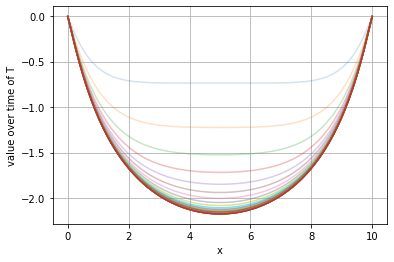

In [7]:
# Test the solution
num_points = 80
a=0
b=10
x_values = np.linspace(a , b,  num_points)
T0 = np.zeros_like(x_values)
max_time = 100.0
alpha = 0.5
tau = 0.2

my_elliptic_solver = EllipticSolver(x_values, T0, max_time, alpha, tau)
t_solution, y_solution = my_elliptic_solver.integrate_using_solve_ivp()

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 4 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = y_solution[:,i]
        plt.plot(x_values, f_t, label=labelt, alpha=((t_i+20)/(max_time+20)))

plt.xlabel('x')
plt.ylabel('value over time of T')
plt.grid()

The error in the final solution is 0.00036870310315358746


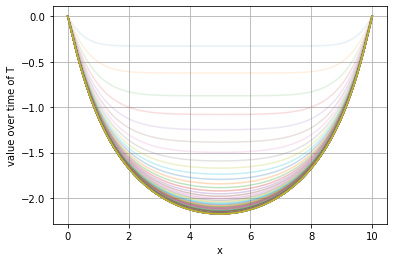

In [14]:
# Test the solution
num_points = 80
a=0
b=10
x_values = np.linspace(a , b,  num_points)
T0 = np.zeros_like(x_values)
max_time = 100.0
alpha = 0.5
tau = 0.2
num_steps = 6000

my_elliptic_solver = EllipticSolver(x_values, T0, max_time, alpha, tau)
t_solution, y_solution = my_elliptic_solver.integrate_using_implicit_method(num_steps)

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 100 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = y_solution[:,i]
        plt.plot(x_values, f_t, label=labelt, alpha=((t_i+10)/(max_time+10)))

plt.xlabel('x')
plt.ylabel('value over time of T')
plt.grid()